In [26]:
import sys, os, time, datetime, h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from scipy.stats import norm, expon, chi2, uniform, chisquare

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.constraints import Constraint
from tensorflow.keras import metrics, losses, optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Layer
from tensorflow import Variable
from tensorflow import linalg as la

In [2]:
from NPLM.NNutils import *
from NPLM.PLOTutils import *

# Parameters

In [5]:
seed = 5839
np.random.seed(seed)
print('Random seed: '+str(seed))

# statistics                                                                                                                                                     
N_ref      = 200000
N_Bkg      = 2000
N_Sig      = 0
N_R        = N_ref
N_D        = N_Bkg

# nuisance  
correction = 'SHAPE' #'', 'NORM', 'SHAPE'
Scale   = 0
Norm    = 0
sigma_s = 0.15
sigma_n = 0.15

# training time                                                                                                                                                  
total_epochs_tau   = 20000
patience_tau       = 1000
total_epochs_delta = 20000
patience_delta     = 1000

# architecture                                                                                                                                                   
inputsize          = 1
latentsize         = 4
n_layers           = 1
BSMweight_clipping = 9
layers             = [inputsize]
for _ in range(n_layers):
    layers.append(latentsize)
layers.append(1)
print(layers)
hidden_layers      = layers[1:-1]
BSMarchitecture    = layers
BSMdf              = compute_df(input_size=BSMarchitecture[0], hidden_layers=BSMarchitecture[1:-1])

Random seed: 5839
[1, 4, 1]


In [6]:
bins_code = {                                                                                                                                                                                                                                                                         
    'mass': np.arange(0, 10, 0.1)                                                                                                                             
}  
ymax_code = {                                                                                                                                                                                                                                                                       
    'mass': 15                                                                                                                             
}  
xlabel_code = {                                                                                                                                                                                                                                                                        
    'mass': r'$m_{ll}$',                                                                                                                            
}  
feature_labels = list(bins_code.keys())

# DATA

In [7]:
N_Bkg_Pois  = np.random.poisson(lam=N_Bkg*np.exp(Norm), size=1)[0]
if N_Sig:
    N_Sig_Pois = np.random.poisson(lam=N_Sig*np.exp(Norm), size=1)[0]

featureData = np.random.exponential(scale=np.exp(1*Scale), size=(N_Bkg_Pois, 1))
if N_Sig:
    featureSig  = np.random.normal(loc=6.4, scale=0.16, size=(N_Sig_Pois,1))*np.exp(Scale)
    featureData = np.concatenate((featureData, featureSig), axis=0)
featureRef  = np.random.exponential(scale=1., size=(N_ref, 1))
feature     = np.concatenate((featureData, featureRef), axis=0)

# target                                                                                                                                                         
targetData  = np.ones_like(featureData)
targetRef   = np.zeros_like(featureRef)
weightsData = np.ones_like(featureData)
weightsRef  = np.ones_like(featureRef)*N_D*1./N_R
target      = np.concatenate((targetData, targetRef), axis=0)
weights     = np.concatenate((weightsData, weightsRef), axis=0)
target      = np.concatenate((target, weights), axis=1)

batch_size  = feature.shape[0]
inputsize   = feature.shape[1]

# plot input samples

## toy experiment: sig+bkg sample

<ipython-input-6-3fc6fb49bda1>:31: RuntimeWarning: invalid value encountered in true_divide
  plt.errorbar(x, hD[0]/hR[0], yerr=np.sqrt(hD[0])/hR[0], ls='', marker='o', label ='DATA/REF', color='black')


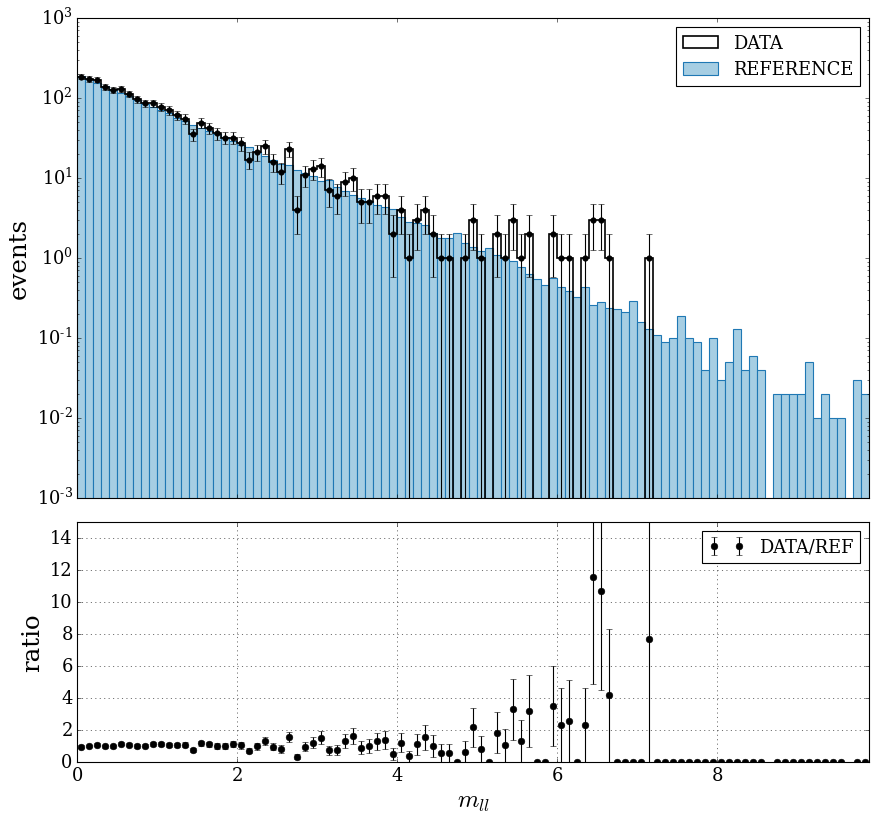

In [6]:
REF    = feature[target[:, 0]==0]
DATA   = feature[target[:, 0]==1]
weight = target[:, 1]

weight_REF       = weight[target[:, 0]==0]
weight_DATA      = weight[target[:, 0]==1]

plt_i = 0
for key in feature_labels:
    bins = bins_code[key]
    plt.rcParams["font.family"] = "serif"
    plt.style.use('classic')
    fig = plt.figure(figsize=(10, 10))                                                                                                                                            
    fig.patch.set_facecolor('white')                                                                                                                                              
    ax1 = fig.add_axes([0., 0.33, 0.99, 0.6])        
    hD = plt.hist(DATA[:, plt_i],weights=weight_DATA, 
                  bins=bins, label='DATA', color='black', lw=1.5, histtype='step', zorder=4)
    hR = plt.hist(REF[:, plt_i], weights=weight_REF, color='#a6cee3',     
                  ec='#1f78b4', bins=bins, lw=1, label='REFERENCE')
    plt.errorbar(0.5*(bins[1:]+bins[:-1]), hD[0],  yerr= np.sqrt(hD[0]), color='black', ls='', marker='o', ms=5, zorder=3)
    font = font_manager.FontProperties(family='serif', size=16)
    l    = plt.legend(fontsize=18, prop=font)
    font = font_manager.FontProperties(family='serif', size=18) 
    plt.tick_params(axis='x', which='both',    labelbottom=False)
    plt.yticks(fontsize=16, fontname='serif')
    plt.ylabel('events', fontsize=22, fontname='serif')
    plt.xlim(bins[0], bins[-1])
    plt.yscale('log')
    ax2 = fig.add_axes([0., 0., 0.99, 0.3]) 
    x = 0.5*(bins[1:]+bins[:-1])
    plt.errorbar(x, hD[0]/hR[0], yerr=np.sqrt(hD[0])/hR[0], ls='', marker='o', label ='DATA/REF', color='black')
    font = font_manager.FontProperties(family='serif', size=16)
    plt.legend(fontsize=18, prop=font)
    plt.xlabel(xlabel_code[key], fontsize=22, fontname='serif')
    plt.ylabel('ratio', fontsize=22, fontname='serif')
    plt.ylim(0., ymax_code[key])
    plt.yticks(fontsize=16, fontname='serif')
    plt.xticks(fontsize=16, fontname='serif')
    plt.xlim(bins[0], bins[-1])
    
    plt.grid() 
    plt.show()
    plt_i+=1

## toy experiment: bkg-only sample

<ipython-input-8-3fc6fb49bda1>:31: RuntimeWarning: invalid value encountered in true_divide
  plt.errorbar(x, hD[0]/hR[0], yerr=np.sqrt(hD[0])/hR[0], ls='', marker='o', label ='DATA/REF', color='black')


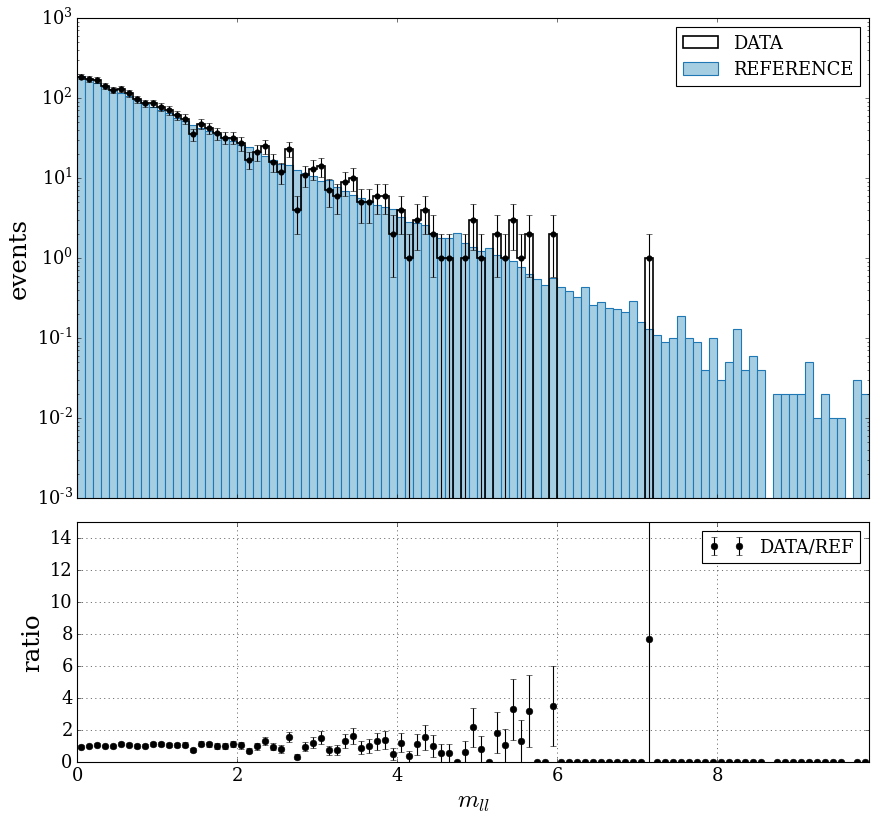

# NN model arguments 

In [9]:
NU0_S     = np.random.normal(loc=Scale, scale=sigma_s, size=1)[0]
NU0_N     = np.random.normal(loc=Norm, scale=sigma_n, size=1)[0]
NUR_S     = np.array([0. ])
NUR_N     = 0
NU_S      = np.array([0. ])
NU_N      = 0
SIGMA_S   = np.array([sigma_s])
SIGMA_N   = sigma_n 
                                                                                                                                                     
input_shape     = (None, inputsize)
                                                                                                            


### Taylor's expansion models for shape effects

In [10]:
weights_file  = './LINEAR_Parametric_EXPO1D_batches_ref40000_bkg40000_sigmaS0.1_-1.0_-0.5_0.5_1.0_patience300_epochs30000_layers1_4_1_actrelu_model_weights9300.h5'

sigma = weights_file.split('sigmaS', 1)[1]                                                                                                                 
sigma = float(sigma.split('_', 1)[0])                                                                                                                        
scale_list=weights_file.split('sigma', 1)[1]                                                                                   
scale_list=scale_list.split('_patience', 1)[0]                                                                                                               
scale_list=np.array([float(s) for s in scale_list.split('_')[1:]])*sigma  
print(scale_list)
shape_std = np.std(scale_list)
activation= weights_file.split('act', 1)[1]
activation=activation.split('_', 1)[0]
wclip=None
if 'wclip' in weights_file:
    wclip= weights_file.split('wclip', 1)[1]
    wclip = float(wclip.split('/', 1)[0])

layers=weights_file.split('layers', 1)[1]
layers= layers.split('_act', 1)[0]
architecture = [int(l) for l in layers.split('_')]

poly_degree = 0
if 'LINEAR' in weights_file:
    poly_degree = 1
elif 'QUADRATIC' in weights_file:
    poly_degree = 2
elif 'CUBIC' in weights_file:
    poly_degree = 3
else:
    print('Unrecognized number of degree for polynomial parametric net in file: \n%s'%(weights_file))
    poly_degree = None
    
scale_parNN = {
    'poly_degree'   : poly_degree,
    'architectures' : [architecture for i in range(poly_degree)],
    'wclips'        : [wclip for i in range(poly_degree)],
    'activation'    : activation,
    'shape_std'     : shape_std,
    'weights_file'  : weights_file
    }

parNN_list = { 
    'scale': scale_parNN,
    }


[-0.1  -0.05  0.05  0.1 ]


# Tau term

In [11]:
tau = imperfect_model(input_shape=input_shape,
                      NU_S=NU_S, NUR_S=NUR_S, NU0_S=NU0_S, SIGMA_S=SIGMA_S, 
                      NU_N=NU_N, NUR_N=NUR_N, NU0_N=NU0_N, SIGMA_N=SIGMA_N,
                      correction='SHAPE', shape_dictionary_list=[parNN_list['scale']],
                      BSMarchitecture=BSMarchitecture, BSMweight_clipping=BSMweight_clipping, train_f=True, train_nu=True)
print(tau.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ParNet (TaylorExpansionNet)  multiple                  13        
_________________________________________________________________
bs_mfinder_net_1 (BSMfinderN multiple                  13        
Total params: 34
Trainable params: 15
Non-trainable params: 19
_________________________________________________________________
None


In [12]:
tau.compile(loss=imperfect_loss,  optimizer='adam')

In [13]:
t0=time.time()
hist_tau = tau.fit(feature, target, batch_size=batch_size, epochs=total_epochs_tau, verbose=False)
t1=time.time()
print('Training time (seconds):')
print(t1-t0)

Training time (seconds):
974.8837916851044


In [14]:
# metrics                                                                                                                                                        
if correction=='SHAPE':
    scale_tau = np.array(hist_tau.history['shape_0'])
    norm_tau  = np.array(hist_tau.history['norm_0'])
    print('sb_opt: %f, eb_opt: %f'%(scale_tau[-1], norm_tau[-1]))
elif correction=='NORM':
    norm_tau  = np.array(hist_tau.history['norm_0'])
    print('eb_opt: %f'%(norm_tau[-1]))

loss_tau  = np.array(hist_tau.history['loss'])
# test statistic                                                                                                                                                                                                                                                                                                               
final_loss = loss_tau[-1]
tau_OBS    = -2*final_loss
print('tau_OBS: %f'%(tau_OBS))

sb_opt: -0.001667, eb_opt: 0.102813
tau_OBS: 4.276488


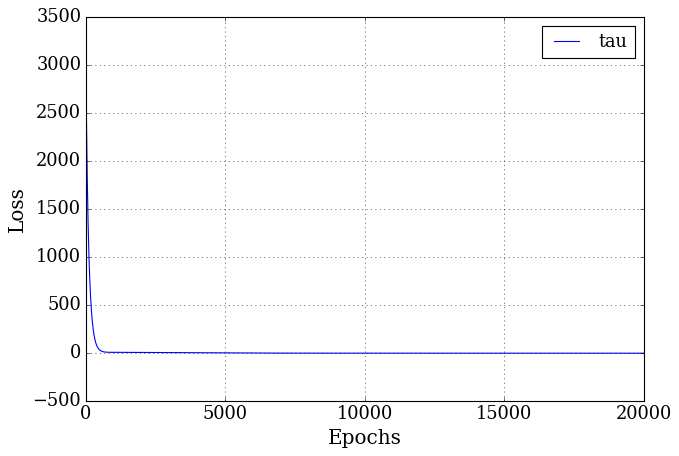

In [15]:
fig = plt.figure(figsize=(9,6))                                                                                                                                            
fig.patch.set_facecolor('white') 
plt.plot(loss_tau, label='tau')
plt.legend(prop=font, fontsize=18)
plt.ylabel('Loss', fontsize=18, fontname='serif')
plt.xlabel('Epochs', fontsize=18, fontname='serif')
plt.xticks(fontsize=16, fontname='serif')
plt.yticks(fontsize=16, fontname='serif')
plt.grid()
plt.show()
plt.close()

## Delta term

In [16]:
if not correction=='':
    delta = imperfect_model(input_shape=input_shape,
                          NU_S=NU_S, NUR_S=NUR_S, NU0_S=NU0_S, SIGMA_S=SIGMA_S, 
                          NU_N=NU_N, NUR_N=NUR_N, NU0_N=NU0_N, SIGMA_N=SIGMA_N,
                          correction='SHAPE', shape_dictionary_list=[parNN_list['scale']],
                          BSMarchitecture=BSMarchitecture, BSMweight_clipping=BSMweight_clipping, train_f=False, train_nu=True)

    print(delta.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ParNet (TaylorExpansionNet)  multiple                  13        
Total params: 21
Trainable params: 2
Non-trainable params: 19
_________________________________________________________________
None


In [17]:
if not correction=='':
    opt  = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=0.0000001)
    delta.compile(loss=imperfect_loss,  optimizer=opt)

In [18]:
if not correction=='':
    t0=time.time()
    hist_delta = delta.fit(feature, target, batch_size=batch_size, epochs=total_epochs_delta, verbose=False)
    t1=time.time()
    print('Training time (seconds):')
    print(t1-t0)

Training time (seconds):
338.6509609222412


In [19]:
# metrics                                                                                                                                                        
if correction=='SHAPE':
    scale_delta = np.array(hist_delta.history['shape_0'])
    norm_delta  = np.array(hist_delta.history['norm_0'])
    print('sb_opt: %f, eb_opt: %f'%(scale_delta[-1], norm_delta[-1]))
elif correction=='NORM':
    norm_delta  = np.array(hist_delta.history['norm_0'])
    print('eb_opt: %f'%(norm_delta[-1]))

if not correction=='':
    loss_delta  = np.array(hist_delta.history['loss'])
    # test statistic                                                                                                                                                                                                                                                                                                               
    final_loss   = loss_delta[-1]
    delta_OBS    = -2*final_loss
    print('delta_OBS: %f'%(delta_OBS))

sb_opt: -0.006553, eb_opt: 0.033426
delta_OBS: 2.505816


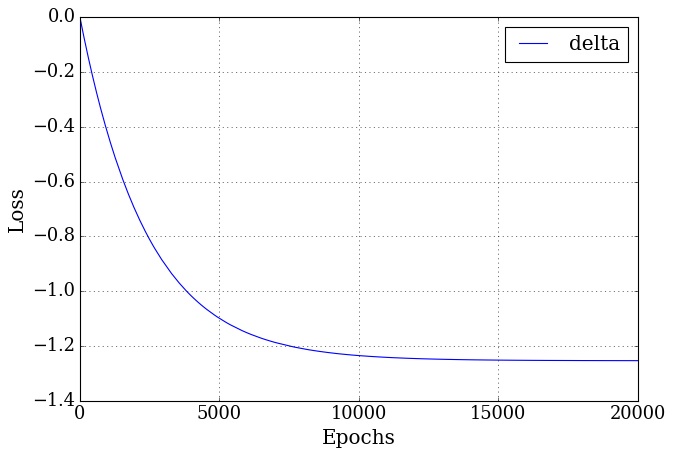

In [20]:
if not correction=='':
    fig = plt.figure(figsize=(9,6))                                                                                                                                            
    fig.patch.set_facecolor('white') 
    plt.plot(loss_delta, label='delta')
    font = font_manager.FontProperties(family='serif', size=18) 
    plt.legend(prop=font, fontsize=18)
    plt.ylabel('Loss', fontsize=18, fontname='serif')
    plt.xlabel('Epochs', fontsize=18, fontname='serif')
    plt.xticks(fontsize=16, fontname='serif')
    plt.yticks(fontsize=16, fontname='serif')
    plt.grid()
    plt.show()
    plt.close()

# NN reconstruction

In [21]:
REF    = feature[target[:, 0]==0]
DATA   = feature[target[:, 0]==1]
weight = target[:, 1]

weight_REF       = weight[target[:, 0]==0]
weight_DATA      = weight[target[:, 0]==1]
output_delta_ref = delta.predict(REF)
output_tau_ref   = tau.predict(REF)

## toy experiment: sig+bkg sample

<ipython-input-46-d14baf2f7477>:43: RuntimeWarning: invalid value encountered in true_divide
  plt.errorbar(x, hD[0]/hR[0], yerr=np.sqrt(hD[0])/hR[0], ls='', marker='o', label ='DATA/REF', color='black')
<ipython-input-46-d14baf2f7477>:44: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(x, hN[0]/hR[0], label =r'$\tau$ RECO/REF', color='#b2df8a', lw=3)
<ipython-input-46-d14baf2f7477>:45: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(x, hN2[0]/hR[0], ls='--', label =r'$\Delta$ RECO/REF', color='#33a02c', lw=3)


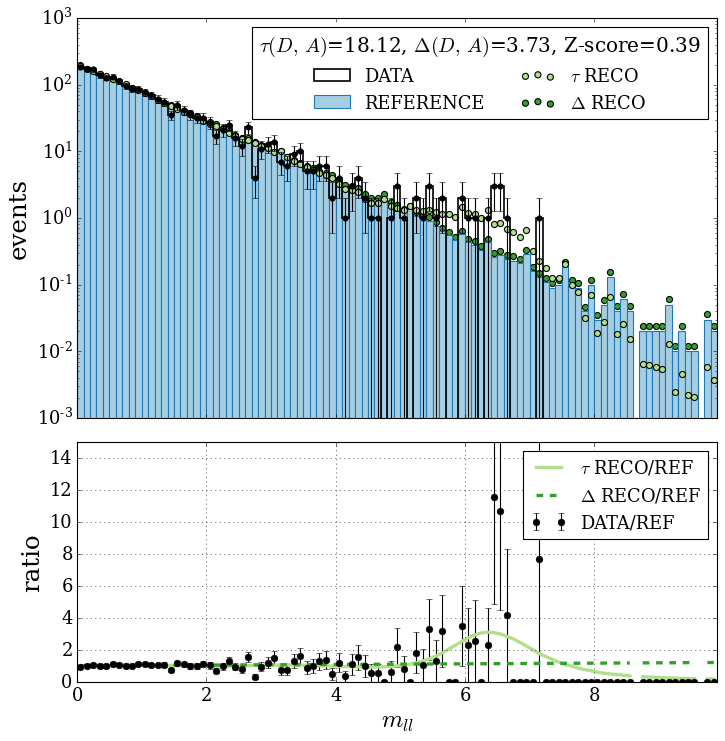

In [47]:
plot_reconstruction(BSMdf, DATA, weight_DATA, REF, weight_REF, 
                        tau_OBS, output_tau_ref,  
                        feature_labels, bins_code, xlabel_code, 
                        delta_OBS=delta_OBS, output_delta_ref=output_delta_ref, 
                    save=False, save_path='', save_name='')

## toy experiment: bkg-only sample

<ipython-input-28-95f5dcbb0407>:49: RuntimeWarning: invalid value encountered in true_divide
  plt.errorbar(x, hD[0]/hR[0], yerr=np.sqrt(hD[0])/hR[0], ls='', marker='o', label ='DATA/REF', color='black')
<ipython-input-28-95f5dcbb0407>:50: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(x, hN[0]/hR[0], label =r'$\tau$ RECO/REF', color='#b2df8a', lw=3)
<ipython-input-28-95f5dcbb0407>:52: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(x, hN2[0]/hR[0], ls='--', label =r'$\Delta$ RECO/REF', color='#33a02c', lw=3)


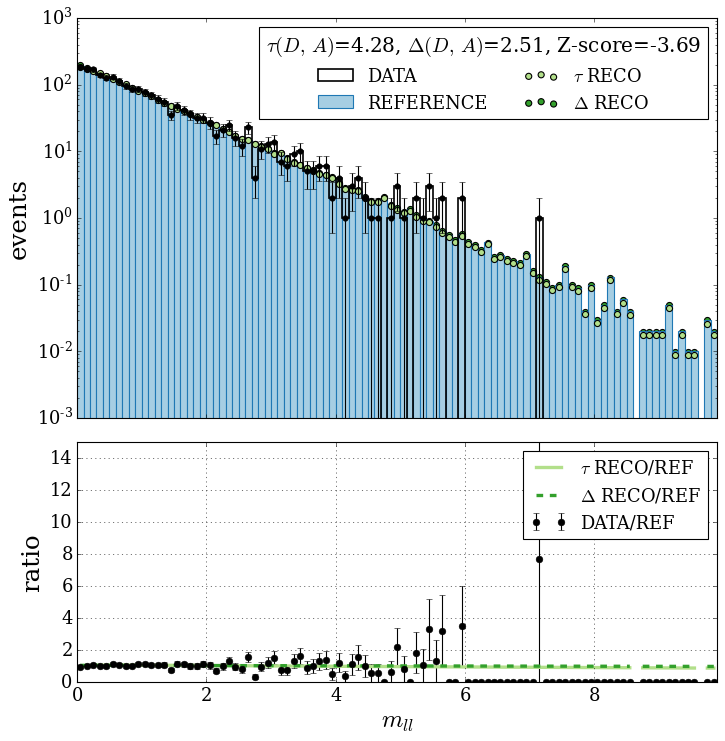

In [31]:
plot_reconstruction(BSMdf, DATA, weight_DATA, REF, weight_REF, 
                        tau_OBS, output_tau_ref,  
                        feature_labels, bins_code, xlabel_code, 
                        delta_OBS=delta_OBS, output_delta_ref=output_delta_ref, 
                    save=False, save_path='', save_name='')

<ipython-input-28-95f5dcbb0407>:49: RuntimeWarning: invalid value encountered in true_divide
  plt.errorbar(x, hD[0]/hR[0], yerr=np.sqrt(hD[0])/hR[0], ls='', marker='o', label ='DATA/REF', color='black')
<ipython-input-28-95f5dcbb0407>:50: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(x, hN[0]/hR[0], label =r'$\tau$ RECO/REF', color='#b2df8a', lw=3)


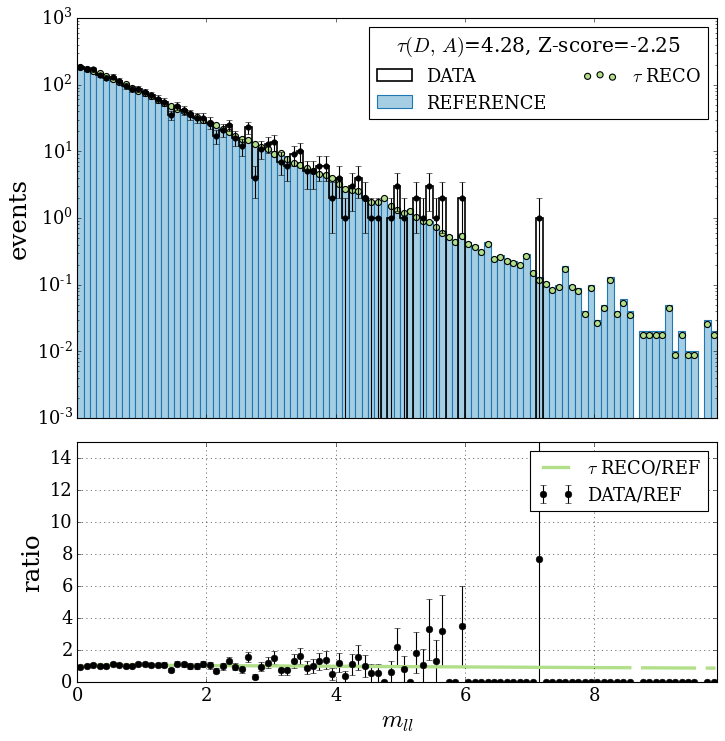

In [30]:
plot_reconstruction(BSMdf, DATA, weight_DATA, REF, weight_REF, 
                        tau_OBS, output_tau_ref,  
                        feature_labels, bins_code, xlabel_code, 
                        delta_OBS=None, output_delta_ref=None)